## To do
- [ ] trocar linreg por logreg
- [x] trocar gb por mlp
- [x] tunning (hyperparameters, topics)

# Detect malicious users in WhatsApp public groups
* Malicious users repeatedly and intentionaly spread misinformation (bots, cyborgs, trolls)
* Low credibility / gullible users
* Superspreaders / influencers/ persuaders
* Source of fake news (SOFN)

Estimate the credibility of users

In [1]:
#utils
import emoji, re, string, time, os
from utils import get_test_metrics
from utils import preprocess
from utils import get_user_features, get_top_users
import pandas as pd
import numpy as np
from scipy.stats import randint
import pickle
import math

#nlp
import nltk
from nltk.corpus import stopwords
import spacy
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns

#features
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

#models
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble  import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import tree


#data balancing
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler


%matplotlib inline
sns.set(style="darkgrid")

# Load data

In [2]:
#df.rename(columns={'sharings':'shares'},inplace=True)
#df.to_csv('data/2018/fakeWhatsApp.BR_2018.csv',index=False)

In [3]:
# messages
df = pd.read_csv('data/2018/fakeWhatsApp.BR_2018.csv')
df_texts = pd.read_csv('data/2018/high_quality_labels/fakeWhatsApp.BR_2018_preprocessed_texts.csv')
df = pd.concat([df, df_texts], axis=1)
df.drop(columns=['Unnamed: 0'],inplace=True)
df.sample(10)

/home/cabral/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (3,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,date,hour,ddi,country,country_iso3,ddd,state,group,midia,url,characters,words,viral,shares,text,misinformation,preprocessed_text,preprocessed_text_stemmed,preprocessed_text_lemma
207274,-6414149115255382605,17/08/18,21:42,55,BRASIL,BRA,79,Sergipe,2018_54,1,0,25,4,0,1,<Arquivo de mídia oculto>,0,< arquivo midia oculto >,< arqu mid ocult >,< arquivar midia ocultar >
158999,3319661316459229233,28/10/18,22:25,55,BRASIL,BRA,85,Ceará,2018_41,1,0,25,4,0,1,<Arquivo de mídia oculto>,0,< arquivo midia oculto >,< arqu mid ocult >,< arquivar midia ocultar >
261047,-2871364284514194267,06/09/18,13:25,55,BRASIL,BRA,16,São Paulo,2018_59,1,0,25,4,0,1,<Arquivo de mídia oculto>,0,< arquivo midia oculto >,< arqu mid ocult >,< arquivar midia ocultar >
48133,3253737420019672981,01/08/18,20:31,55,BRASIL,BRA,21,Rio de Janeiro,2018_12,0,1,187,6,1,3,Por um Brasil Melhor - https://www.vakinha.com...,0,brasil melhor - . vakinha,brasil melhor - . vak,brasil melhor - . vakinha
213769,5380364650481982264,09/09/18,10:29,55,BRASIL,BRA,79,Sergipe,2018_54,0,0,56,10,0,1,Rita adiciona esse rapaz ele ta do nosso lado....,0,rita adiciona rapaz ta lado . obrigado .,rit adic rapaz ta lad . obrig .,rita adicionar rapaz ta lado . obrigar .
6854,-9017538359726301337,17/09/18,15:32,55,BRASIL,BRA,89,Piauí,2018_3,1,0,25,4,0,1,<Arquivo de mídia oculto>,0,< arquivo midia oculto >,< arqu mid ocult >,< arquivar midia ocultar >
233912,9215223805058184204,04/09/18,15:41,55,BRASIL,BRA,31,Minas Gerais,2018_56,1,0,25,4,0,1,<Arquivo de mídia oculto>,0,< arquivo midia oculto >,< arqu mid ocult >,< arquivar midia ocultar >
136464,-7706837922039093730,07/09/18,07:47,55,BRASIL,BRA,34,Minas Gerais,2018_39,0,0,32,4,0,1,Sempre tirar dúvidas !!!obrigado,0,sempre tirar duvidas ! ! ! obrigado,sempr tir duvid ! ! ! obrig,sempre tirar duvidar ! ! ! obrigar
84174,-7832160074158908642,25/08/18,19:48,55,BRASIL,BRA,37,Minas Gerais,2018_25,1,0,25,4,0,1,<Arquivo de mídia oculto>,0,< arquivo midia oculto >,< arqu mid ocult >,< arquivar midia ocultar >
189340,9081507925284347565,23/10/18,20:04,55,BRASIL,BRA,61,Distrito Federal,2018_45,0,0,91,18,0,1,Tem toda uma equipe de segurança. Estive na po...,0,toda equipe seguranca . posse dilma esquema se...,tod equip seguranc . poss dilm esquem seguranc...,todo equipar seguranca . posse dilma esquema s...


In [4]:
df['viral'] = [1 if mis==1 else vir for mis,vir in zip(df['misinformation'],df['viral'])]

In [5]:
df['misinformation'].value_counts()

0    270867
1     11734
Name: misinformation, dtype: int64

In [6]:
# users
#start = time.time()
#df_users = get_top_users(df,None)
#df_users.to_csv('data/2018/users.csv',index=False)
#end = time.time()
#print((end-start)/60)


df_users = pd.read_csv('data/2018/users.csv')
# filter users that haven't sent viral messages
#df_users.dropna(subset=['viral_messages'],inplace=True)
df_users.sort_values('viral_misinformation_ratio', ascending=False).head(10)
# laplace smoothing, additive smoothing
# somar uma quantidade no denominador +1
# considerando uma priori

,id,groups,number_of_messages,texts,text_ratio,midia,midia_ratio,virals,viral_ratio,degree_centrality,strenght,viral_degree_centrality,viral_strenght,misinformation,misinformation_degree_centrality,misinformation_strenght,misinformation_ratio,viral_misinformation_ratio,viral_messages
1832,-6466419814190162853,1,28,25,0.892857,3,0.107143,2,0.071429,152,4256,89,178,2,71,142.0,0.071429,1.0,"arquivar ano [num] "" enterrar "" redar globo de..."
2539,-8975904124756039174,1,15,11,0.733333,4,0.266667,2,0.133333,17,255,7,14,2,3,6.0,0.133333,1.0,enverr amigo ver whatsapp . \n \n * analisar f...
1017,5276233012699937445,1,64,40,0.625000,24,0.375000,1,0.015625,277,17728,138,138,1,109,109.0,0.015625,1.0,. bahianoticias \n \n * alar [num] mil baiano ...
2543,-7699231987068317212,1,15,8,0.533333,7,0.466667,3,0.200000,325,4875,176,528,3,118,354.0,0.200000,1.0,"golpe , golpe , golpe . . . adelio autorizar d..."
2549,-7543604740380005677,1,15,11,0.733333,4,0.266667,1,0.066667,91,1365,26,26,1,18,18.0,0.066667,1.0,agora fake news pegar pesar
1005,5276818640357464974,1,65,20,0.307692,45,0.692308,2,0.030769,167,10855,84,168,2,63,126.0,0.030769,1.0,❌ 🆘 ❌ 🆘 ❌ 🆘 ❌ 🆘 ❌ \n \n atarncao ! ! ! ! ! tse...
2553,-1262571921909839756,1,14,7,0.500000,7,0.500000,5,0.357143,147,2058,91,455,5,71,355.0,0.357143,1.0,video mostrar esquererdo querer transformar pa...
4491,8037235706411836879,1,2,1,0.500000,1,0.500000,1,0.500000,277,554,138,138,1,109,109.0,0.500000,1.0,[num]o turno : voce selecionado participar pes...
1001,-7393395746959340148,1,65,49,0.753846,16,0.246154,3,0.046154,187,12155,94,282,3,79,237.0,0.046154,1.0,comecaram remocoes simbolos comunista todo bra...
2557,8133598396863014761,1,14,4,0.285714,10,0.714286,1,0.071429,272,3808,105,105,1,73,73.0,0.071429,1.0,"divulgar cena , covarde mal especie . \n \n \n..."


## Definitions
* **credibility:** probability of a viral message of a user don't contain misinformation
* **superspreaders or influencers:** users with high level of ``viral strenght``
* **misinformers:** users with a high number of misinformation

To consideration: users that sent a lot of viral messages may have a average or high credibility, due the quantity of information that they sent even if they sent a lot o misinformation, as user ``-9166534760459654877`` for example. So even if the user is a misinformer or superspreader, he can have high credibility by our definition. The opposite is also true, a user with low credibility may not have sent a high quantitiy of misinformation, but has a high proportion in his viral messages, as user ``	-6466419814190162853`` for example.<br>
Possible solution: use the number of misinformation (normalized between 0 and 1) in the scoring of credibility.<br>
Normalization: z = (x-min(x))/(max(x)-min(x))

* **untrustworthiness:** viral misinformation ratio smoothed by laplace smoothing (https://en.wikipedia.org/wiki/Additive_smoothing)

In [7]:
df_users.columns

Index(['id', 'groups', 'number_of_messages', 'texts', 'text_ratio', 'midia',
       'midia_ratio', 'virals', 'viral_ratio', 'degree_centrality', 'strenght',
       'viral_degree_centrality', 'viral_strenght', 'misinformation',
       'misinformation_degree_centrality', 'misinformation_strenght',
       'misinformation_ratio', 'viral_misinformation_ratio', 'viral_messages'],
      dtype='object')

In [8]:
def normalization(x):
    z = (x-min(x))/(max(x)-min(x))
    return z

def get_untrustworthiness(df):
    variables = ['misinformation_strenght', 'viral_misinformation_ratio']
    z = []
    for v in variables:
        z.append(normalization(df[v]))
    z = np.array(z).transpose()
    return z.mean(axis=1)  

#df_users['untrustworthiness'] = get_untrustworthiness(df_users)
#df_users['untrustworthiness'] = normalization(df_users['untrustworthiness'])
df_users['untrustworthiness'] = df_users['misinformation']/(df_users['virals']+1)

# Distribution of activity

In [9]:
# outlier: Limite superior: Q3+1,5(Q3−Q1)
def outlier(s):
    q3 = s.quantile(0.75)
    q1 = s.quantile(0.25)
    out = q3+1.5*(q3-q1)
    return out

count    5364.000000
mean       52.684750
std       138.060355
min         1.000000
25%         3.000000
50%        13.000000
75%        45.000000
max      4396.000000
Name: number_of_messages, dtype: float64

outliers 108.0


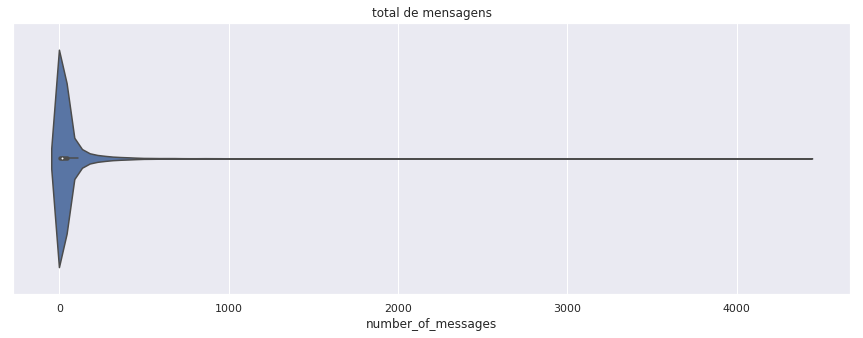

In [10]:
# active users
values = df_users['number_of_messages']
plt.figure(figsize=(15,5))
plt.title('total de mensagens')
ax = sns.violinplot(x=values,color ='C0')
print(values.describe())
print()
print('outliers',outlier(values))

# Defining malicious users using the distributions of behavior variables
We consider only the active users for that

In [11]:
# only active users
# this definition is very important! We have to choose carefully!!!
df_active_users = df_users[(df_users['virals'] > 0) & (df_users['number_of_messages'] > 45)]

count    1185.000000
mean        0.046047
std         0.050641
min         0.000000
25%         0.014663
50%         0.033333
75%         0.065789
max         0.979167
Name: misinformation_ratio, dtype: float64

outliers 0.1424795493131656


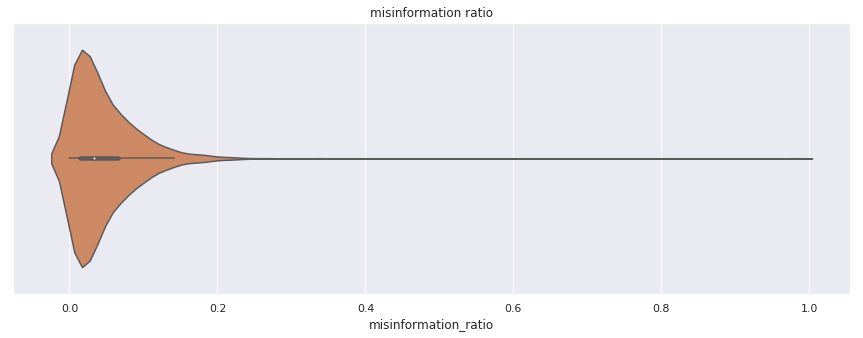

In [12]:
# source
values = (df_active_users['misinformation_ratio'])
plt.figure(figsize=(15,5))
plt.title('misinformation ratio')
ax = sns.violinplot(x=values,color ='C1')
print(values.describe())
print()
print('outliers',outlier(values))
mis_ratio_threshold = outlier(values)


count     1185.000000
mean       619.770464
std       1126.666214
min          0.000000
25%        105.000000
50%        246.000000
75%        654.000000
max      11635.000000
Name: misinformation_strenght, dtype: float64

outliers 1477.5


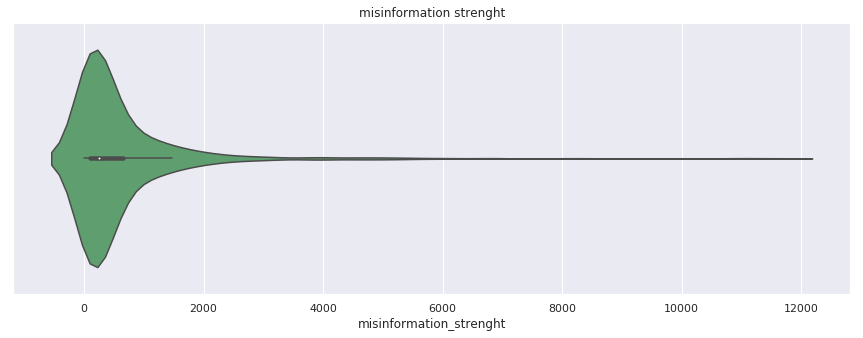

In [13]:
# absolute value
values = df_active_users['misinformation_strenght']
plt.figure(figsize=(15,5))
plt.title('misinformation strenght')
ax = sns.violinplot(x=values, color = 'C2')
print(values.describe())
print()
print('outliers',outlier(values))

mis_strenght_threshold = outlier(values)

count    1185.000000
mean      100.021097
std        66.414727
min         5.000000
25%        59.000000
50%        82.000000
75%       122.000000
max       714.000000
Name: misinformation_degree_centrality, dtype: float64

outliers 216.5


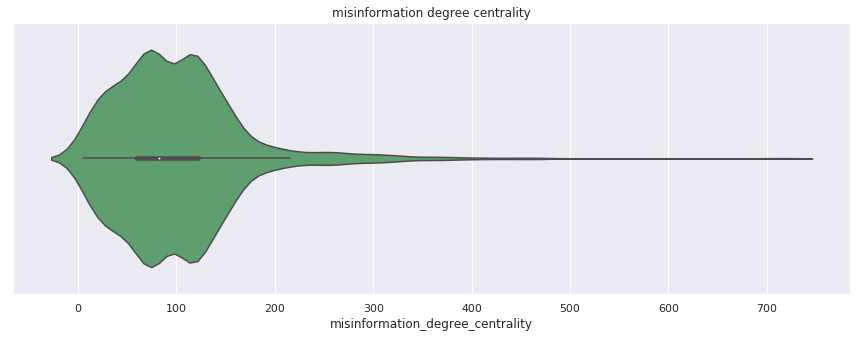

In [14]:
# absolute value
values = df_active_users['misinformation_degree_centrality']
plt.figure(figsize=(15,5))
plt.title('misinformation degree centrality')
ax = sns.violinplot(x=values, color = 'C2')
print(values.describe())
print()
print('outliers',outlier(values))

mis_degree_threshold = outlier(values)

count     1185.00000
mean      1498.71730
std       2987.91578
min          7.00000
25%        248.00000
50%        604.00000
75%       1558.00000
max      49346.00000
Name: viral_strenght, dtype: float64

outliers 3523.0


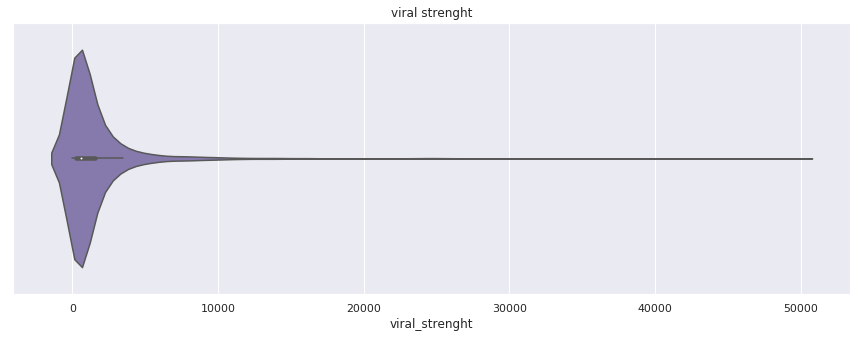

In [15]:
# relative to users value

values = df_active_users['viral_strenght']
plt.figure(figsize=(15,5))
plt.title('viral strenght')
ax = sns.violinplot(x=values, color = 'C4')
print(values.describe())
print()
print('outliers',outlier(values))

viral_strenght_threshold = outlier(values)

count    1185.000000
mean        0.461097
std         0.230980
min         0.000000
25%         0.333333
50%         0.500000
75%         0.633333
max         0.979167
Name: untrustworthiness, dtype: float64

outliers 1.0833333333333333


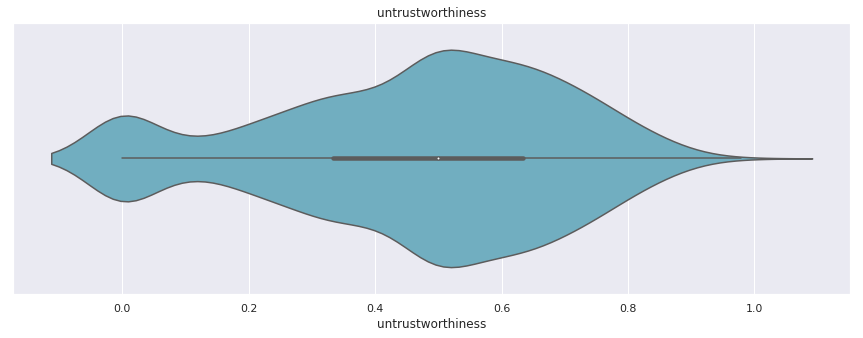

In [16]:
# relative to users value
values = df_active_users['untrustworthiness']
plt.figure(figsize=(15,5))
plt.title('untrustworthiness')
ax = sns.violinplot(x=values, color = 'C9')
print(values.describe())
print()
print('outliers',outlier(values))

untrustworthiness_threshold = outlier(values)

# Hypothesis
Most of misinformation is spread by malicious / untrustful users

In [17]:
df_users.columns

Index(['id', 'groups', 'number_of_messages', 'texts', 'text_ratio', 'midia',
       'midia_ratio', 'virals', 'viral_ratio', 'degree_centrality', 'strenght',
       'viral_degree_centrality', 'viral_strenght', 'misinformation',
       'misinformation_degree_centrality', 'misinformation_strenght',
       'misinformation_ratio', 'viral_misinformation_ratio', 'viral_messages',
       'untrustworthiness'],
      dtype='object')

## Testing the hypothesis

In [18]:
df_malicious = df_users[df_users['untrustworthiness'] >= 0.3]
malicious = set(df_malicious['id'])

# misinformation
total_mis = len(df[df['misinformation']==1])
print('total misinformation: ',total_mis)

def messages_by_superspreaders(user,superspreaders):
    if user in superspreaders:
        return True
    else:
        return False
superspreader_mask = []
for u in df['id']:
    superspreader_mask.append(messages_by_superspreaders(u,malicious))    
df_superspreaders = df[superspreader_mask]
df_superspreaders = df_superspreaders[df_superspreaders['misinformation']==1]

print('total users:',len(df_users))
print('total untrustful users: {a:1d} ({b:.1f}%)'.format(a = len(malicious), b = len(malicious)*100/len(df_users)))
print('proportion of misinformation sent by untrustful users: {a:.1f}%'.format(a = len(df_superspreaders)*100/total_mis))

total misinformation:  11734
total users: 5364
total untrustful users: 1883 (35.1%)
proportion of misinformation sent by untrustful users: 93.9%


# Selecting only the active users based in data

In [19]:
# user data
df_active_users = df_users[(df_users['virals'] > 0)]

# Experiment design


### Models
* Classic machine learning regression
    * Linear regression
    * MLP

### Features
* User features: ``'groups', 'number_of_messages', 'texts', 'text_ratio', 'midia', 'midia_ratio', 'virals', 'viral_ratio', 'degree_centrality', 'strenght', 'viral_degree_centrality','viral_strenght'``
* y: ``'misinformation_ratio'``
* Text features: ``'viral_messages'`` 
    * Topics (LDA)

### Metrics
* RMSE

## Scenarios
* A: user features
* B: topics
* B: user features + text


# User representation

In [20]:
df_users.corr()['untrustworthiness']

id                                  0.005434
groups                              0.058160
number_of_messages                  0.297743
texts                               0.215872
text_ratio                         -0.109661
midia                               0.343967
midia_ratio                         0.109661
virals                              0.280502
viral_ratio                         0.371565
degree_centrality                   0.013660
strenght                            0.263337
viral_degree_centrality             0.042965
viral_strenght                      0.262757
misinformation                      0.405200
misinformation_degree_centrality    0.054408
misinformation_strenght             0.383431
misinformation_ratio                0.516321
viral_misinformation_ratio          0.952918
untrustworthiness                   1.000000
Name: untrustworthiness, dtype: float64

In [21]:
df_active_users.columns

Index(['id', 'groups', 'number_of_messages', 'texts', 'text_ratio', 'midia',
       'midia_ratio', 'virals', 'viral_ratio', 'degree_centrality', 'strenght',
       'viral_degree_centrality', 'viral_strenght', 'misinformation',
       'misinformation_degree_centrality', 'misinformation_strenght',
       'misinformation_ratio', 'viral_misinformation_ratio', 'viral_messages',
       'untrustworthiness'],
      dtype='object')

In [22]:
user_features = ['number_of_messages', 'texts', 'text_ratio', 'midia',
           'midia_ratio', 'virals', 'viral_ratio', 'degree_centrality', 'strenght',
           'viral_degree_centrality', 'viral_strenght']
X = df_active_users[user_features]
y = df_active_users['untrustworthiness']
X.shape

(2620, 11)

### Feature selection

In [23]:
# univariate analysis
X.std()

number_of_messages           186.411503
texts                        122.723183
text_ratio                     0.233079
midia                         85.344266
midia_ratio                    0.233079
virals                        21.184147
viral_ratio                    0.174888
degree_centrality            147.260901
strenght                   39399.397124
viral_degree_centrality       77.706476
viral_strenght              2115.323650
dtype: float64

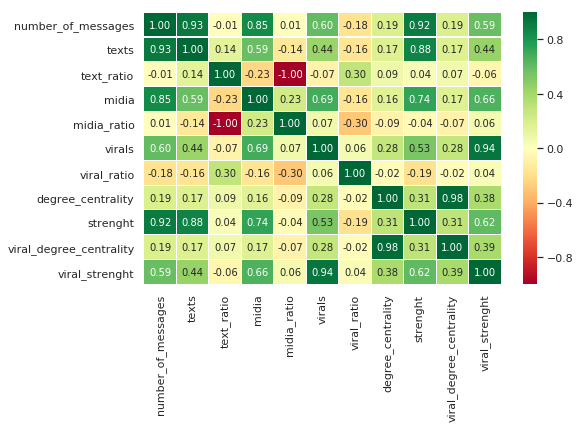

In [24]:
#get correlations of each features in dataset
corrmat = X.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(8,5))
#plot heat map
# sns.heatmap(df_similar, annot=True, fmt='.2f', linewidths=.1)
g=sns.heatmap(X[top_corr_features].corr(),annot=True, fmt='.2f', linewidths=.1,cmap="RdYlGn")

[0.05470725 0.06241734 0.09700196 0.07813868 0.07176365 0.13163915
 0.08900861 0.09908901 0.1268871  0.07464011 0.11470714]


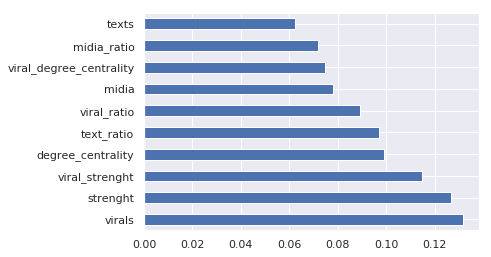

In [25]:
# feature importance

from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

# Evaluation functions

In [26]:
def pred_tfidf(reg,X_test):
    y_pred = []
    for x in X_test:
    #if vector is from null text
        if x.sum()==0:
            y_pred.append(.0)
        else:
            pred = reg.predict(x)[0]
            y_pred.append(pred)
    return y_pred

def pred_topics(reg,X_test):
    y_pred = []
    for x in X_test:
    #if vector is from null text
        if np.all(x == x[0]):
            y_pred.append(0.0)
        else:
            pred = reg.predict(x)[0]
            y_pred.append(pred)
    return y_pred

def train_test_reg(reg,X_train,X_test,y_train,y_test, text_features = None):
    reg.fit(X_train, y_train)

    if text_features == 'tfidf':
        y_pred = pred_tfidf(reg,X_test)
    elif text_features == 'lda':
        y_pred = pred_topics(reg,X_test)
    else:
        y_pred = reg.predict(X_test)
        
    y_pred = np.clip(y_pred,0,1)    
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    print('rmse: {a:.3f}'.format(a=rmse))
    return rmse,y_pred

def z_score(X_train,X_test):
    mu = np.mean(X_train, 0)
    sigma = np.std(X_train, 0)
    X_train = (X_train - mu ) / sigma
    X_test = (X_test - mu ) / sigma
    return X_train,X_test

def compare_prediction(y,y_pred):
    for t,p in list(zip(y,y_pred)):
        print('real: {a:.2f}. predict: {b:.2f}'.format(a=t,b=p))
        
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
    

# compare prediction with target

# for t,p in list(zip(y_test,y_pred)):
#     print('real: {a:.2f}. predict: {b:.2f}'.format(a=t,b=p))

In [27]:
# optimal mlp for tfidf
def get_mlp():
    reg = MLPRegressor(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-4, verbose = False, early_stopping = True, 
                   n_iter_no_change = 5, max_iter = 100,
                   hidden_layer_sizes = (100,), alpha = 0.0067, 
                   learning_rate_init = .00026, batch_size = 50)
    return reg

# tunning hyperparameters mlp
n_iter = 10
def random_layers():
    '''
    Create a tuple random of hidden_layer_sizes. 
    '''
    n_layers = np.random.randint(1,4)
    layers_list = []
    for i in range(n_layers):            
        hidden_neurons = np.random.randint(1,15)*25
        layers_list.append(hidden_neurons)
    layers_tuple = tuple(layers_list)
    return layers_tuple

def random_search_mlp(X_train,y_train,n_iter=10):
    
    # hyperparams to optimize
    hidden_layers = []
    alphas = []
    batch_sizes = []
    learning_rate_inits = []
    # sample
    np.random.seed(0)
    for i in range(n_iter):   
        hl = random_layers()
        #print(hl,end = '; ')
        hidden_layers.append(hl)
        ap = 10**np.random.uniform(-6,-2)
        #print(ap, end = '; ')
        alphas.append(ap)
        learning = 10**np.random.uniform(-4,-1)
        #print(learning, end = '; ')
        learning_rate_inits.append(learning)
        batch = np.random.randint(1,5)*50 #math.floor(10**np.random.uniform(1.5,2.6)) #np.random.randint(2,30)*10
        #print(batch)
        batch_sizes.append(batch)

    # tunning
    X_train_v, X_val, y_train_v, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    best_rmse = 1000
    i = 0
    for hl,bs,al,lri in zip(hidden_layers,batch_sizes,alphas,learning_rate_inits):
        
        reg = optimized_mlp(hl,bs,al,lri)

        print(i, end= ' ')
        i+=1
        print()
        print('hidden layers: {a}; alpha: {b:.5f}; learning rate: {c:.5f}; batch: {d}'.format(a=hl,b=al,c=lri,d=bs))    
        reg.fit(X_train_v, y_train_v)
        y_pred = reg.predict(X_val)        
        y_pred = np.clip(y_pred,0,1)

        rmse = mean_squared_error(y_val, y_pred, squared=False)
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = (hl,bs,al,lri)

        #print('validation rmse: {a:.3f}'.format(a=rmse))


    hl,bs,al,lri = best_params
    print()
    print('--------------------')
    print('BEST PARAMETERS (validation rmse = {a:.3f})'.format(a=best_rmse))
    print('hidden layers: {a}; alpha: {b:.5f}; learning rate: {c:.5f}; batch: {d}'.format(a=hl,b=al,c=lri,d=bs))
    print('--------------------')
    return hl,bs,al,lri

def optimized_mlp(hl,bs,al,lri):
    reg = MLPRegressor(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-4, verbose = False, early_stopping = True, 
                   n_iter_no_change = 5, max_iter = 100,
                   hidden_layer_sizes = hl, alpha = al, 
                   learning_rate_init = lri, batch_size = bs)
    return reg
    
    

# User features

In [28]:
print('trustable users?')
df_active_users[df_active_users['untrustworthiness'] == 0]

trustable users?


,id,groups,number_of_messages,texts,text_ratio,midia,midia_ratio,virals,viral_ratio,degree_centrality,strenght,viral_degree_centrality,viral_strenght,misinformation,misinformation_degree_centrality,misinformation_strenght,misinformation_ratio,viral_misinformation_ratio,viral_messages,untrustworthiness
9,3201344459315743060,1,1126,950,0.843694,176,0.156306,2,0.001776,272,306272,105,210,0,73,0.0,0.0,0.0,bem vir grupar direito capitao alberto neto [n...,0.0
19,-3545133711641780471,1,932,873,0.936695,59,0.063305,1,0.001073,272,253504,105,105,0,73,0.0,0.0,0.0,* urgente ! ! ! * \n live bolsonaro daqui pouc...,0.0
91,5799803585252829017,1,450,384,0.853333,66,0.146667,1,0.002222,272,122400,105,105,0,73,0.0,0.0,0.0,oi galera . . . . . independente vcs irao vota...,0.0
178,-3198159623833756640,1,304,145,0.476974,159,0.523026,3,0.009868,152,46208,89,267,0,71,0.0,0.0,0.0,petista procurar teta segundo feirar<>marinho ...,0.0
214,-1005480812249449457,1,273,183,0.670330,90,0.329670,1,0.003663,152,41496,89,89,0,71,0.0,0.0,0.0,haddade balear agora pouco . 😔,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4949,6183038366216158784,1,1,1,1.000000,0,0.000000,1,1.000000,307,307,162,162,0,124,0.0,0.0,0.0,ir fazer campanha inteligente garantir vitoria...,0.0
5157,4716421855862788687,1,1,1,1.000000,0,0.000000,1,1.000000,56,56,34,34,0,26,0.0,0.0,0.0,* : * : * : * : * : * : * : * : * : * : * \n *...,0.0
5179,-4188663224858239237,1,1,1,1.000000,0,0.000000,1,1.000000,93,93,57,57,0,46,0.0,0.0,0.0,* avisar utilidade publicar * \n \n brasil par...,0.0
5250,-5214655400732106639,1,1,1,1.000000,0,0.000000,1,1.000000,139,139,69,69,0,59,0.0,0.0,0.0,ir fazer campanha inteligente garantir vitoria...,0.0


In [29]:
user_features = ['number_of_messages','midia_ratio', 'viral_ratio', 
                 'degree_centrality', 'strenght',
                 'viral_degree_centrality', 'viral_strenght']
X = df_active_users[user_features]
y = df_active_users['untrustworthiness']
# split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# z_score
X_train,X_test=z_score(X_train,X_test)
print(X.shape)
print(X_train.shape)
print(X_test.shape)

(2620, 7)
(2096, 7)
(524, 7)


In [30]:
from sklearn.linear_model import LinearRegression #logistic regression
from sklearn.metrics import mean_squared_error
reg = LinearRegression()
print('linear regression + user features')
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

linear regression + user features
rmse: 0.243


In [31]:
#compare_prediction(y_test,y_pred)

In [32]:
from sklearn.neural_network import MLPRegressor
print('mlp + user features')
reg = MLPRegressor(random_state=0,)
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)
#compare_prediction(y_test,y_pred)

mlp + user features
rmse: 0.232


In [33]:
reg = get_mlp()
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

rmse: 0.235


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [34]:
print('mlp + user features')
hl,bs,al,lri = random_search_mlp(X_train,y_train,n_iter)
reg = optimized_mlp(hl,bs,al,lri)
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

mlp + user features
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 200
1 
hidden layers: (100, 150); alpha: 0.00003; learning rate: 0.00078; batch: 50
2 
hidden layers: (325,); alpha: 0.00003; learning rate: 0.02372; batch: 200
3 
hidden layers: (225, 50, 150); alpha: 0.00221; learning rate: 0.00103; batch: 50
4 
hidden layers: (100,); alpha: 0.00674; learning rate: 0.00026; batch: 50
5 
hidden layers: (100, 225, 50); alpha: 0.00007; learning rate: 0.02196; batch: 150
6 
hidden layers: (50,); alpha: 0.00000; learning rate: 0.06823; batch: 200
7 
hidden layers: (125, 200, 100); alpha: 0.00001; learning rate: 0.01625; batch: 50
8 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 50
9 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100

--------------------
BEST PARAMETERS (validation rmse = 0.210)
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 200
--------------------
rmse: 0.231


# Text features

In [130]:
X = df_active_users['viral_messages']
y = df_active_users['untrustworthiness']
X_texts_train, X_texts_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# nan_mask = X_texts_train.notna().values
# X_texts_train = X_texts_train[nan_mask]
# y_train = y_train[nan_mask]
# print(y_train.shape)
X_texts_test = ['' if type(x) != str else x for x in X_texts_test]

(2096,)


In [134]:
# tf-idf
X_texts_test = ['' if type(x) != str else x for x in X_texts_test]
vectorizer = TfidfVectorizer(max_features = None, ngram_range = (2,2), lowercase = True, token_pattern = r'[^\s]+')
vectorizer.fit(X_texts_train)   
X_train = vectorizer.transform(X_texts_train)
X_test = vectorizer.transform(X_texts_test)
X_train.shape

(2096, 142181)

In [132]:
print('linear regression + tfidf')
reg = LinearRegression()
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

linear regression + tfidf
rmse: 0.397


In [135]:
reg = MLPRegressor(random_state=0)
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

rmse: 0.174


In [136]:
print('mlp + tfidf')
hl,bs,al,lri = random_search_mlp(X_train,y_train,n_iter)
reg = optimized_mlp(hl,bs,al,lri)
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

mlp + tfidf
0 
hidden layers: (150,); alpha: 0.00238; learning rate: 0.03748; batch: 200
1 
hidden layers: (100, 150); alpha: 0.00003; learning rate: 0.00078; batch: 50
2 
hidden layers: (325,); alpha: 0.00003; learning rate: 0.02372; batch: 200
3 
hidden layers: (225, 50, 150); alpha: 0.00221; learning rate: 0.00103; batch: 50
4 
hidden layers: (100,); alpha: 0.00674; learning rate: 0.00026; batch: 50
5 
hidden layers: (100, 225, 50); alpha: 0.00007; learning rate: 0.02196; batch: 150
6 
hidden layers: (50,); alpha: 0.00000; learning rate: 0.06823; batch: 200
7 
hidden layers: (125, 200, 100); alpha: 0.00001; learning rate: 0.01625; batch: 50
8 
hidden layers: (25, 25, 125); alpha: 0.00030; learning rate: 0.00686; batch: 50
9 
hidden layers: (125, 250); alpha: 0.00006; learning rate: 0.00691; batch: 100

--------------------
BEST PARAMETERS (validation rmse = 0.150)
hidden layers: (100,); alpha: 0.00674; learning rate: 0.00026; batch: 50
--------------------
rmse: 0.168


## Topic modeling (LDA)

In [34]:
X = df_active_users['viral_messages']
X_texts_train, X_texts_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_texts_train = ['' if type(x) != str else x for x in X_texts_train]
X_texts_test = ['' if type(x) != str else x for x in X_texts_test]

In [35]:
# topics
from gensim.models import LdaModel
from gensim.corpora.dictionary import Dictionary
n_topics = 100

def train_lda(corpus, n_topics = 100):
    common_texts = [x.split() for x in corpus]
    common_dictionary = Dictionary(common_texts)
    common_corpus = [common_dictionary.doc2bow(text) for text in common_texts]
    lda = LdaModel(common_corpus, num_topics=n_topics)
    return lda, common_dictionary

lda, common_dictionary = train_lda(X_texts_train, n_topics)

In [36]:
# X_texts_test[0]
# arr = tup2array(lda[X_test[0]])
# arr
#np.all(arr == arr[0])

In [37]:
# vectorizing
def tup2array(tuples,n_topics):
    topics = np.zeros(n_topics)
    for t, p in tuples:
        topics[t] = p
    return topics

def vectorize_topics(X,lda):
    X = [lda[x] for x in X]
    X = [tup2array(v,lda.num_topics) for v in X]
    return X

def texts2topics(texts,lda):
    X = [x.split() for x in texts]
    X = [common_dictionary.doc2bow(text) for text in X]
    X = vectorize_topics(X,lda)
    return X
    

X_train = texts2topics(X_texts_train,lda)
X_test = texts2topics(X_texts_test,lda)

In [38]:
print('linear regression + lda')
reg = LinearRegression()
reg.fit(X_train, y_train)
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

linear regression + lda
rmse: 0.222


In [40]:
print('mlp + lda')
# hl,bs,al,lri = random_search_mlp(X_train,y_train,n_iter)
# reg = optimized_mlp(hl,bs,al,lri)
# rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)
reg = get_mlp()
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

mlp + lda
rmse: 0.226


# Combine user features and topics

In [41]:
X_train_lda = np.vstack(X_train)
X_test_lda = np.vstack(X_test)
X_test_lda.shape

(524, 100)

In [42]:
X = df_active_users[user_features]
y = df_active_users['untrustworthiness']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train,X_test=z_score(X_train,X_test)   
X_train = np.concatenate((X_train, X_train_lda), axis=1)
X_test = np.concatenate((X_test, X_test_lda), axis=1)
X_train.shape

(2096, 107)

In [43]:
print('linear regression + user features + lda')
reg = LinearRegression()
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

linear regression + user features + lda
rmse: 0.217


In [44]:
print('mlp + user features + lda')
# hl,bs,al,lri = random_search_mlp(X_train,y_train,n_iter)
# reg = optimized_mlp(hl,bs,al,lri)
reg = get_mlp()
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

mlp + user features + lda
rmse: 0.215


In [69]:
# compare prediction with target
# compare_prediction(y_test,y_pred)

# Combine user features and TF-IDF

In [51]:
X = df_active_users[user_features+['viral_messages']]
y = df_active_users['untrustworthiness']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_texts = X_train['viral_messages']
X_test_texts = X_test['viral_messages']

X_train = X_train[user_features].to_numpy()
X_test = X_test[user_features].to_numpy()
X_train, X_test = z_score(X_train,X_test)

vectorizer = TfidfVectorizer(max_features = 5000, ngram_range = (2,2), lowercase = True, token_pattern = r'[^\s]+')
vectorizer.fit(X_train_texts)   
X_train_tfidf = vectorizer.transform(X_train_texts).todense()
X_test_tfidf = vectorizer.transform(X_test_texts).todense()

X_train = np.concatenate((X_train, X_train_tfidf), axis=1)
X_test = np.concatenate((X_test, X_test_tfidf), axis=1)
X_train.shape


(2096, 5007)

In [52]:
print('linear regression + user features + tfidf')
reg = LinearRegression()
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

linear regression + user features + tfidf
rmse: 0.490


In [53]:
print('mlp + user features + tfidf')
# hl,bs,al,lri = random_search_mlp(X_train,y_train,n_iter)
# reg = optimized_mlp(hl,bs,al,lri)
reg = get_mlp()
rmse, y_pred = train_test_reg(reg,X_train,X_test,y_train,y_test)

mlp + user features + tfidf
rmse: 0.174


# Classify fake news by users credibility

In [67]:
# X = df_active_users[user_features]
# mu = np.mean(X, 0)
# sigma = np.std(X, 0)
# X = (X - mu ) / sigma

# X_texts = ['' if type(x) != str else x for x in df_active_users['viral_messages']]
#lda, common_dictionary = train_lda(X_texts_train)
#X_text_features = texts2topics(X_texts,lda)

In [70]:
# X_concat = np.concatenate((X, X_text_features), axis=1)
# hl,bs,al,lri = random_search_mlp(X_train,y_train,n_iter)
# reg = optimized_mlp(hl,bs,al,lri)
# reg.fit(X_concat, y)

In [35]:
# tf-idf
y = df_active_users['untrustworthiness']
X_texts = ['' if type(x) != str else x for x in df_active_users['viral_messages']]
vectorizer = TfidfVectorizer(max_features = None, ngram_range = (2,2), lowercase = True, token_pattern = r'[^\s]+')
X_tfidf = vectorizer.fit_transform(X_texts)
reg = MLPRegressor(random_state=0)
reg.fit(X_tfidf, y)
X_tfidf.shape

(2620, 154010)

In [36]:
y_pred = reg.predict(X_tfidf)#(X_concat)X_tfidf
y_pred = np.clip(y_pred,0,1)    
rmse = mean_squared_error(y, y_pred, squared=False)
print(rmse)
df_active_users['predicted'] = y_pred

0.03864225291484206


/home/cabral/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [37]:
user_dict = dict(zip(df_active_users['id'], df_active_users['predicted']))

In [38]:
df = df[df['viral']==1]
df_unique = df.drop_duplicates(subset='text')
message_score = []
# get mean credibility of users that sent the news
for m in df_unique['text']:
    df_msg = df[df['text']==m]
    users = df_msg['id'].unique()
    scores = []
    for u in users:
        scores.append(user_dict.get(u, 0.5))
    user_score = pd.Series(index=users,data = scores)
    message_score.append(user_score.mean())

df_unique['message_score'] = message_score 
df_unique['class'] = ['misinformation' if m == 1 else 'non-misinformation' for m in df_unique['misinformation']]

/home/cabral/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/cabral/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


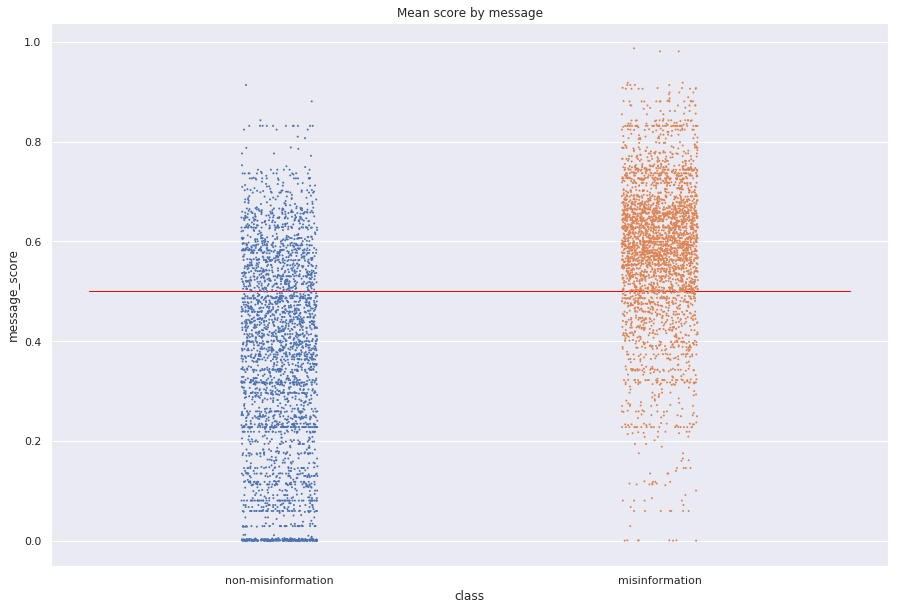

In [83]:
plt.figure(figsize=(15,10))
plt.title('Mean score by message')
sns.stripplot(x='class' ,y="message_score", size=2, data=df_unique)
plt.plot([-.5,1.5], [0.5, 0.5], linewidth=1, color = 'red')

              precision    recall  f1-score   support

           0       0.75      0.71      0.73      3091
           1       0.74      0.77      0.76      3296

    accuracy                           0.74      6387
   macro avg       0.74      0.74      0.74      6387
weighted avg       0.74      0.74      0.74      6387

AUC:  0.8050096702609831


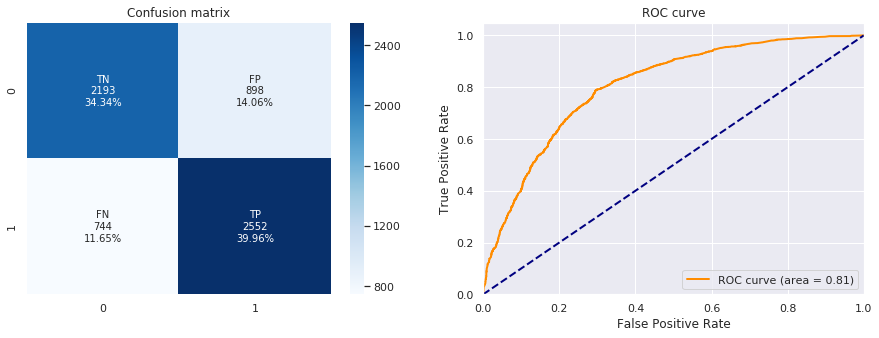

(0.7429152966964145,
 0.7397101449275363,
 0.7276045122760451,
 0.7742718446601942,
 0.7276045122760451,
 0.7565965016305959,
 0.7276045122760451,
 0.8050096702609831)

In [84]:
y = df_unique['misinformation']
y_pred = [1 if x >= 0.5 else 0 for x in df_unique['message_score']]
get_test_metrics(y, y_pred, message_score, full_metrics = True)

### Test data
May contains data leakage

In [ ]:
# X = df_unique['message_score']
# y = df_unique['misinformation']
# X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)
# plt.figure(figsize=(15,10))
# plt.title('Mean score by message')
# sns.stripplot(x=y_test ,y=X_test, size=2)
# plt.plot([-.5,1.5], [0.5, 0.5], linewidth=1, color = 'red')

In [ ]:
# y_pred = [1 if x >= 0.5 else 0 for x in X_test]
# get_test_metrics(y_test, y_pred, X_test, full_metrics = True)

# Fair test
remove the messages from a test set of messages from training set of users

In [39]:
df_unique = df[df['viral']==1].drop_duplicates(subset='text')
X = list(df_unique['preprocessed_text_lemma'])
y = df_unique['misinformation']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)

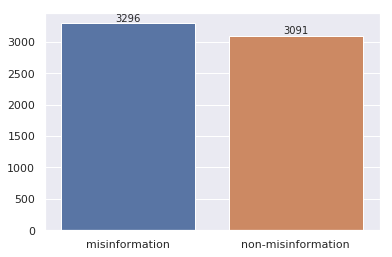

In [40]:
pos_mask = y == 1 
pos = y[pos_mask]
neg_mask = y == 0 
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

In [41]:
print(y.sum()/len(y))

0.516048222952873


In [42]:
# collect only train text data
user_train_texts = []
users = df_active_users['id']
for user in users:
    texts = df[df['id']==user]['preprocessed_text_lemma']
    train_texts = [t for t in texts if t in X_train]
    train_texts = ['' if type(t)!=str else t for t in train_texts]
    train_texts = ' '.join(train_texts)
    user_train_texts.append(train_texts)

X_users = user_train_texts
y_users = df_active_users['untrustworthiness']

In [43]:
vectorizer = TfidfVectorizer(max_features = None, ngram_range = (2,2), lowercase = True, token_pattern = r'[^\s]+')
X_tfidf = vectorizer.fit_transform(X_users)

In [44]:
reg = MLPRegressor(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-4, verbose = True, early_stopping = True, 
                   n_iter_no_change = 3, max_iter = 10,
                   hidden_layer_sizes = (100,), alpha = 0.0067, 
                   learning_rate_init = .00026, batch_size = 50)
reg.fit(X_tfidf,y_users)

Iteration 1, loss = 0.12767530
Validation score: -0.803499
Iteration 2, loss = 0.04759448
Validation score: -0.171546
Iteration 3, loss = 0.02958543
Validation score: 0.071788
Iteration 4, loss = 0.02145127
Validation score: 0.204851
Iteration 5, loss = 0.01706033
Validation score: 0.283659
Iteration 6, loss = 0.01453537
Validation score: 0.346441
Iteration 7, loss = 0.01276775
Validation score: 0.392295
Iteration 8, loss = 0.01163366
Validation score: 0.419209
Iteration 9, loss = 0.01106591
Validation score: 0.449802
Iteration 10, loss = 0.01041680
Validation score: 0.456177


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(alpha=0.0067, batch_size=50, early_stopping=True,
             learning_rate_init=0.00026, max_iter=10, n_iter_no_change=3,
             random_state=42, verbose=True)

In [75]:
y_pred = reg.predict(X_tfidf)
y_pred = np.clip(y_pred,0,1)    
rmse = mean_squared_error(y_users, y_pred, squared=False)
print(rmse)

0.12324245113055866


In [77]:
# probability of a user post a message. viral messages posted by user / total viral messages
total_viral = len(y_train)
## IS THAT CORRECT?!
p_u = df_active_users['viral_ratio']
# P(U) = probability of user post that message = n of times he posted the message/total viral messages he posted

# p(u|f), p(u)
user_dict = dict(zip(df_active_users['id'], zip(y_pred,p_u)))
#user_dict

In [92]:
# # bayes rules (or naive-bayes) to estimate probability of news
# # P(F|U) = P(U|F)*P(F)/P(U)
# priori = y_train.sum()/len(y_train)
# message_score = []
# for m in X_test:
#     df_msg = df[df['preprocessed_text_lemma']==m]
#     users = df_msg['id'].unique()
#     likelihood = []
#     marginal = []
#     for u in users:        
#         user_data = user_dict.get(u, (0.5,1))        
#         likelihood.append(user_data[0])
#         n_times_user_posted_messgae = len(df_msg[df_msg['id']==u])
#         #marginal.append(user_data[1])
#         margin = n_times_user_posted_messgae*user_data[1]
#         marginal.append(margin)
#     prod_likelihood = pd.Series(index=users,data = likelihood).prod()
#     prod_marginal = pd.Series(index=users,data = marginal).prod()
#     posteriori = prod_likelihood*priori/prod_marginal
#     message_score.append(posteriori)

## naive bayes without marginalization
priori = y_train.sum()/len(y_train)
message_score = []
y_pred_mis = []
for m in X_test:
    df_msg = df[df['preprocessed_text_lemma']==m]
    users = df_msg['id'].unique()
    likelihood = []
    marginal = []
    for u in users:        
        user_data = user_dict.get(u, (0.5,1))
        likelihood.append(user_data[0])
        #n_times_user_posted_messgae = len(df_msg[df_msg['id']==u])
        #marginal.append(user_data[1])
        #margin = n_times_user_posted_messgae*user_data[1]
        #marginal.append(margin)
        
    pos_likelihood = pd.Series(index=users,data = likelihood)
    neg_likelihood = 1 - pos_likelihood
    pos_likelihood = pos_likelihood.prod()
    neg_likelihood = neg_likelihood.prod()    
    posteriori_pos = pos_likelihood*priori
    #print(posteriori_pos)
    posteriori_neg = neg_likelihood*(1-priori)
    message_score.append(posteriori_pos)
    if posteriori_pos >= posteriori_neg:
        y_pred_mis.append(1)
    else:
        y_pred_mis.append(0)

#message_score
message_score = np.clip(message_score,0,1)     


#message_score
#message_score = np.clip(message_score,0,1) 


In [97]:
# get mean credibility of users that sent the news

user_dict = dict(zip(df_active_users['id'], y_pred))
message_score = []
for m in X_test:
    df_msg = df[df['preprocessed_text_lemma']==m]
    users = df_msg['id']
    scores = []
    for u in users:
        scores.append(user_dict.get(u, 0.5))
    user_score = pd.Series(index=users,data = scores)
    message_score.append(user_score.mean())

In [98]:
mis = ['misinformation' if m == 1 else 'non-misinformation' for m in y_test]
df_print = pd.DataFrame({'class':mis,'score':message_score})

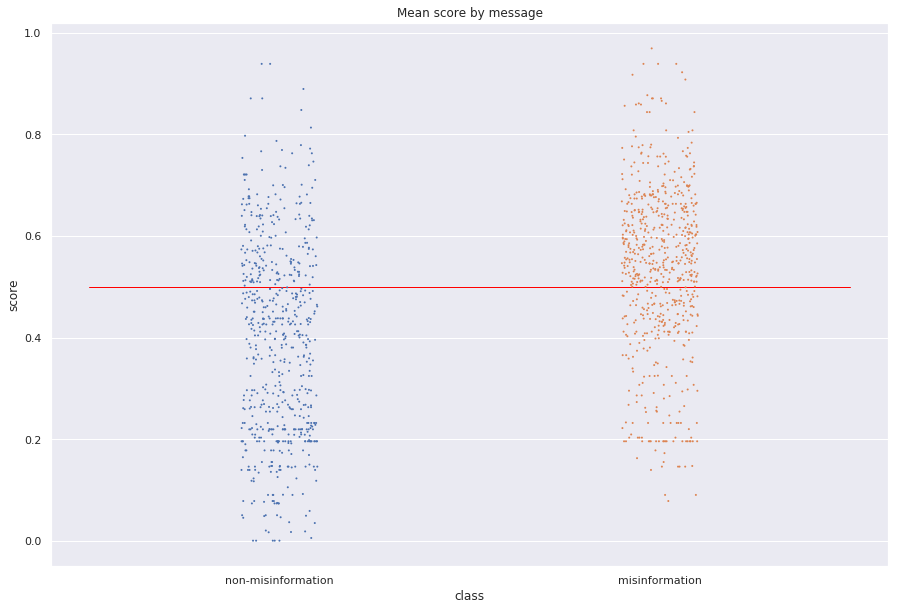

In [99]:
threshold = 0.5
plt.figure(figsize=(15,10))
plt.title('Mean score by message')
sns.stripplot(x='class' ,y='score', size=2, data = df_print)
plt.plot([-.5,1.5], [threshold, threshold], linewidth=1, color = 'red')

              precision    recall  f1-score   support

           0       0.66      0.68      0.67       618
           1       0.69      0.67      0.68       660

    accuracy                           0.67      1278
   macro avg       0.67      0.67      0.67      1278
weighted avg       0.67      0.67      0.67      1278

AUC:  0.7158992841031676


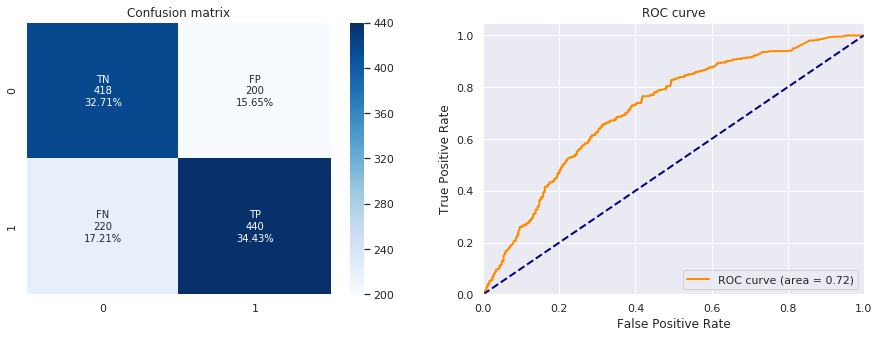

(0.6713615023474179,
 0.6875,
 0.6656050955414011,
 0.6666666666666666,
 0.6656050955414011,
 0.676923076923077,
 0.6656050955414011,
 0.7158992841031676)

In [100]:
#y_pred_mis = [1 if x >= threshold else 0 for x in message_score]
get_test_metrics(y_test, y_pred_mis, message_score, full_metrics = True)

# Using data of only one user for each message

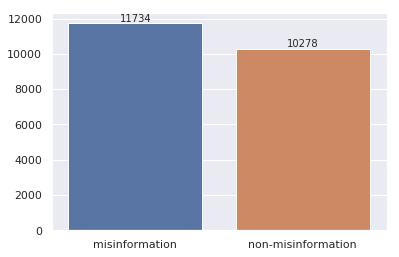

In [119]:
df_viral = df[df['viral']==1]
X = df_viral[['id','preprocessed_text_lemma']]
y = df_viral['misinformation']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=42)

X_train_ids = list(X_train['id'])
X_test_ids = list(X_test['id'])
X_train = list(X_train['preprocessed_text_lemma'])
X_test = list(X_test['preprocessed_text_lemma'])

pos_mask = y == 1 
pos = y[pos_mask]
neg_mask = y == 0 
neg = y[neg_mask]
values = [pos.shape[0],neg.shape[0]]
keys = ['misinformation', 'non-misinformation']
g = sns.barplot(x = keys, y = values)
for p in g.patches:
    g.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., 
                                               p.get_height()), ha = 'center', 
               va = 'center', xytext = (0, 5), textcoords = 'offset points')

In [114]:
# collect only train text data
user_train_texts = []
users = df_active_users['id']

for user in users:
    texts = df[df['id']==user]['preprocessed_text_lemma']
    train_texts = [t for t in texts if t in list(X_train)]
    train_texts = ['' if type(t)!=str else t for t in train_texts]
    train_texts = ' '.join(train_texts)
    user_train_texts.append(train_texts)

X_users = user_train_texts
y_users = df_active_users['untrustworthiness']

In [115]:
vectorizer = TfidfVectorizer(max_features = None, ngram_range = (2,2), lowercase = True, token_pattern = r'[^\s]+')
X_tfidf = vectorizer.fit_transform(X_users)

In [58]:
reg = MLPRegressor(activation = 'relu', solver = 'adam',random_state = 42, 
                   tol = 1e-4, verbose = True, early_stopping = True, 
                   n_iter_no_change = 3, max_iter = 10,
                   hidden_layer_sizes = (100,), alpha = 0.0067, 
                   learning_rate_init = .00026, batch_size = 50)
reg.fit(X_tfidf,y_users)

Iteration 1, loss = 0.11136404
Validation score: -0.498026
Iteration 2, loss = 0.03851977
Validation score: 0.021375
Iteration 3, loss = 0.02395109
Validation score: 0.246254
Iteration 4, loss = 0.01710214
Validation score: 0.370433
Iteration 5, loss = 0.01346461
Validation score: 0.433028
Iteration 6, loss = 0.01123224
Validation score: 0.492119
Iteration 7, loss = 0.00994242
Validation score: 0.517838
Iteration 8, loss = 0.00919838
Validation score: 0.527550
Iteration 9, loss = 0.00840194
Validation score: 0.560241
Iteration 10, loss = 0.00783668
Validation score: 0.567261


/home/cabral/anaconda3/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:585: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPRegressor(alpha=0.0067, batch_size=50, early_stopping=True,
             learning_rate_init=0.00026, max_iter=10, n_iter_no_change=3,
             random_state=42, verbose=True)

In [130]:
y_pred = reg.predict(X_tfidf)
y_pred = np.clip(y_pred,0,1)    
rmse = mean_squared_error(y_users, y_pred, squared=False)
print(rmse)

0.09487167112725786


In [143]:
# probability of a user post a message. viral messages posted by user / total viral messages
total_viral = len(y_train)
priori = y_train.sum()/total_viral
## IS THAT CORRECT?!
p_u = 1/df_active_users['virals']
# P(U) = probability of user post that message = n of times he posted the message/total viral messages he posted

# p(u|f), p(u)
user_dict = dict(zip(df_active_users['id'], zip(y_pred,p_u)))

# #don't calculate the marginal. choose the higher between neg and pos
# posteriori_pos = []
# posteriori_neg = []
# for u,m in zip(X_test_ids,X_test):
#     likelihood, marginal = user_dict.get(u, (1,1))
#     n_times_user_posted_message = len(df_viral[(df_viral['id']==u) & (df_viral['preprocessed_text_lemma']==m)])
#     posteriori_pos.append(likelihood*priori)
#     posteriori_neg.append((1-likelihood)*(1-priori))
# message_score = posteriori_pos

# use the marginal (is the marginal wrong?)
# posteriori=[]
# for u,m in zip(X_test_ids,X_test):
#     likelihood, marginal = user_dict.get(u, (1,1))
#     n_times_user_posted_message = len(df_viral[(df_viral['id']==u) & (df_viral['preprocessed_text_lemma']==m)])
#     marginal = marginal*n_times_user_posted_message    
#     posteriori.append(likelihood*priori/marginal)
#     #print(posteriori[-1],likelihood,marginal)
# message_score = np.clip(posteriori,0,1) 

# use only credibility of user that sent the message
user_dict = dict(zip(df_active_users['id'], y_pred))
message_score = []
for u in list(X_test_ids):
    user_score = user_dict.get(u, 0.5)
    message_score.append(user_score)

In [144]:
mis = ['misinformation' if m == 1 else 'non-misinformation' for m in y_test]
df_print = pd.DataFrame({'class':mis,'score':message_score})

              precision    recall  f1-score   support

           0       0.66      0.62      0.64      2056
           1       0.68      0.72      0.70      2347

    accuracy                           0.67      4403
   macro avg       0.67      0.67      0.67      4403
weighted avg       0.67      0.67      0.67      4403

AUC:  0.7197340051626466


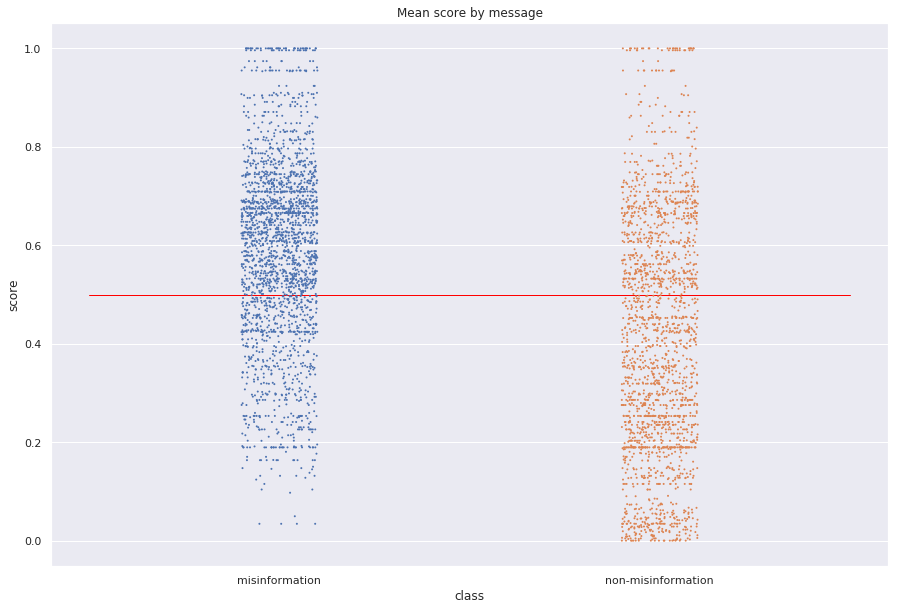

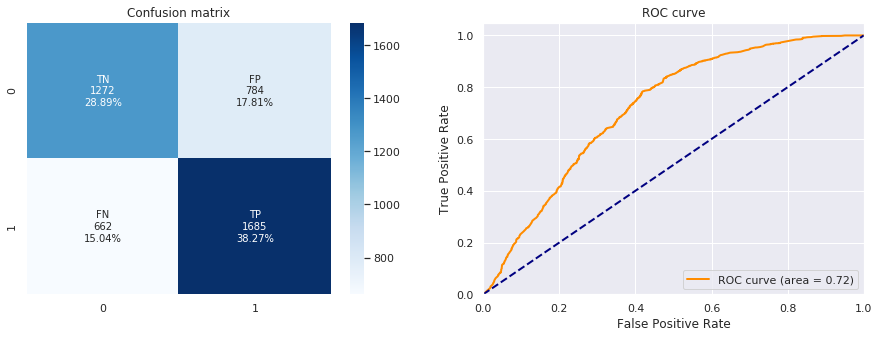

(0.6715875539404951,
 0.6824625354394491,
 0.6375939849624059,
 0.717937792927141,
 0.6375939849624059,
 0.699750830564784,
 0.6375939849624059,
 0.7197340051626466)

In [145]:
threshold = 0.5
plt.figure(figsize=(15,10))
plt.title('Mean score by message')
sns.stripplot(x='class' ,y='score', size=2, data = df_print)
plt.plot([-.5,1.5], [threshold, threshold], linewidth=1, color = 'red')

#y_pred_mis = [1 if pos >= neg else 0 for pos,neg in zip(posteriori_pos,posteriori_neg)]
y_pred_mis = [1 if x >= threshold else 0 for x in message_score]

get_test_metrics(y_test, y_pred_mis, message_score, full_metrics = True)

# Identifying superspreaders
Users that shared a lot of fake news

In [109]:
df_users.head(3)

,id,groups,number_of_messages,texts,text_ratio,midia,midia_ratio,virals,viral_ratio,degree_centrality,strenght,viral_degree_centrality,viral_strenght,misinformation,misinformation_degree_centrality,misinformation_strenght,misinformation_ratio,viral_misinformation_ratio,viral_messages,untrustworthiness
0,-3818310068976662355,1,4396,3742,0.851228,654,0.148772,24,0.005460,152,668192,89,2136,11,71,781.0,0.002502,0.458333,"- casar poder ajudar , colocar adesivo carro /...",0.440000
1,5782050016593913959,11,2332,972,0.416810,1360,0.583190,226,0.096913,1640,498105,889,24683,77,714,6752.0,0.033019,0.340708,"apo tres escola militar irar final soletrar , ...",0.339207
2,-2072140886659020977,3,2064,948,0.459302,1116,0.540698,232,0.112403,525,389426,294,23399,85,243,6828.0,0.041182,0.366379,kkk urna sao fraudar kkk desculpar ha ja dar n...,0.364807


count     5364.000000
mean       161.322893
std        587.399755
min          0.000000
25%          0.000000
50%          0.000000
75%        109.000000
max      11635.000000
Name: misinformation_strenght, dtype: float64

outliers 272.5


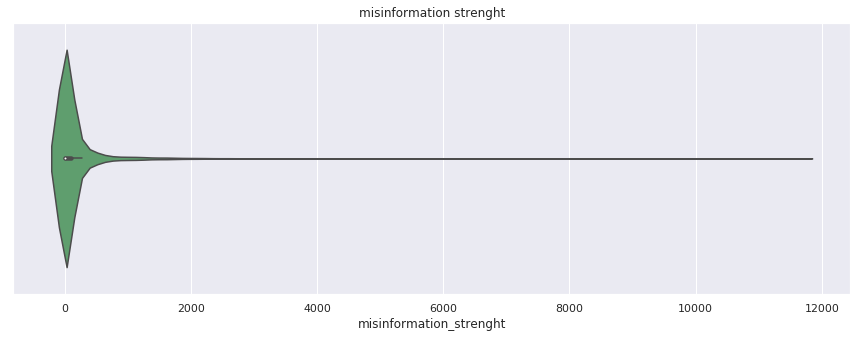

In [112]:
# absolute value
values = df_users['misinformation_strenght']
plt.figure(figsize=(15,5))
plt.title('misinformation strenght')
ax = sns.violinplot(x=values, color = 'C2')
print(values.describe())
print()
print('outliers',outlier(values))
mis_strenght_threshold = outlier(values)

In [119]:
df_malicious = df_users[df_users['misinformation_strenght'] >= mis_strenght_threshold]
malicious = set(df_malicious['id'])

# misinformation
total_mis = len(df[df['misinformation']==1])
print('total misinformation: ',total_mis)

def messages_by_superspreaders(user,superspreaders):
    if user in superspreaders:
        return True
    else:
        return False
superspreader_mask = []
for u in df['id']:
    superspreader_mask.append(messages_by_superspreaders(u,malicious))    
df_superspreaders = df[superspreader_mask]
df_superspreaders = df_superspreaders[df_superspreaders['misinformation']==1]

print('total users:',len(df_users))
print('total untrustful users: {a:1d} ({b:.1f}%)'.format(a = len(malicious), b = len(malicious)*100/len(df_users)))
print('proportion of misinformation sent by untrustful users: {a:.1f}%'.format(a = len(df_superspreaders)*100/total_mis))

total misinformation:  11734
total users: 5364
total untrustful users: 678 (12.6%)
proportion of misinformation sent by untrustful users: 76.1%


In [120]:
df_users['superspreader'] = [1 if m > mis_strenght_threshold else 0 for m in df_users['misinformation_strenght']]

count     5364.000000
mean       388.623788
std       1530.802515
min          0.000000
25%          0.000000
50%          0.000000
75%        210.000000
max      49346.000000
Name: viral_strenght, dtype: float64

outliers 525.0


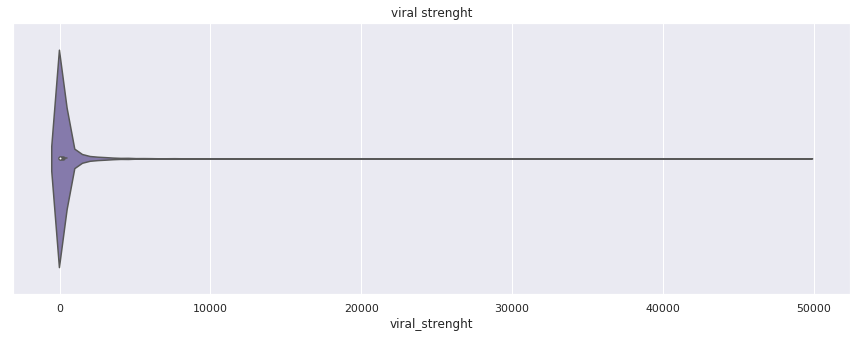

In [121]:
# relative to users value

values = df_users['viral_strenght']
plt.figure(figsize=(15,5))
plt.title('viral strenght')
ax = sns.violinplot(x=values, color = 'C4')
print(values.describe())
print()
print('outliers',outlier(values))

viral_strenght_threshold = outlier(values)

# Detection by threshold

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      4686
           1       0.79      0.91      0.85       678

    accuracy                           0.96      5364
   macro avg       0.89      0.94      0.91      5364
weighted avg       0.96      0.96      0.96      5364



(0.9584265473527218,
 0.7905491698595147,
 0.9759361174058487,
 0.9129793510324484,
 0.9759361174058487,
 0.8473648186173853,
 0.9759361174058487,
 0)

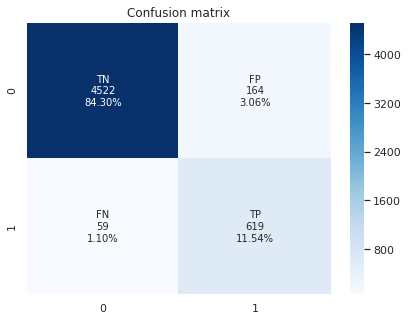

In [123]:
# only by viral strenght outlier and without train-test split
y = df_users['superspreader']
y_pred = [1 if m > viral_strenght_threshold else 0 for m in df_users['viral_strenght']]
get_test_metrics(y, y_pred, full_metrics = True)

## Using credibility models

In [124]:
df_users.columns

Index(['id', 'groups', 'number_of_messages', 'texts', 'text_ratio', 'midia',
       'midia_ratio', 'virals', 'viral_ratio', 'degree_centrality', 'strenght',
       'viral_degree_centrality', 'viral_strenght', 'misinformation',
       'misinformation_degree_centrality', 'misinformation_strenght',
       'misinformation_ratio', 'viral_misinformation_ratio', 'viral_messages',
       'untrustworthiness', 'superspreader'],
      dtype='object')

In [158]:
# using credibility
X = df_users[['viral_messages','viral_strenght']]
y = df_users[['untrustworthiness','superspreader']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_texts_train = X_train['viral_messages']
X_texts_test = X_test['viral_messages']
y_train = y_train['untrustworthiness']
y_test_untrust = y_test['untrustworthiness']
y_test_superspreader = y_test['superspreader']
X_test_viral = X_test['viral_strenght']

In [151]:
# tf-idf
X_texts_train = ['' if type(x) != str else x for x in X_texts_train]
X_texts_test = ['' if type(x) != str else x for x in X_texts_test]
vectorizer = TfidfVectorizer(max_features = None, ngram_range = (2,2), lowercase = True, token_pattern = r'[^\s]+')
vectorizer.fit(X_texts_train)   
X_train_tfidf = vectorizer.transform(X_texts_train)
X_test_tfidf = vectorizer.transform(X_texts_test)
X_train_tfidf.shape

(4291, 141164)

In [152]:
print('linear regression + tfidf')
reg = LinearRegression()
rmse, y_pred = train_test_reg(reg,X_train_tfidf,X_test_tfidf,y_train,y_test_untrust)

linear regression + tfidf
rmse: 0.201


In [155]:
reg = optimized_mlp(hl,bs,al,lri)
rmse, y_pred = train_test_reg(reg,X_train_tfidf,X_test_tfidf,y_train,y_test_untrust)

rmse: 0.147


In [156]:
compare_prediction(y_test_untrust,y_pred)

real: 0.00. predict: 0.03
real: 0.33. predict: 0.21
real: 0.00. predict: 0.03
real: 0.80. predict: 0.42
real: 0.00. predict: 0.03
real: 0.38. predict: 0.41
real: 0.50. predict: 0.00
real: 0.00. predict: 0.05
real: 0.00. predict: 0.03
real: 0.00. predict: 0.03
real: 0.29. predict: 0.45
real: 0.50. predict: 0.57
real: 0.64. predict: 0.52
real: 0.50. predict: 0.47
real: 0.00. predict: 0.03
real: 0.00. predict: 0.01
real: 0.00. predict: 0.03
real: 0.00. predict: 0.03
real: 0.00. predict: 0.03
real: 0.00. predict: 0.03
real: 0.46. predict: 0.50
real: 0.00. predict: 0.03
real: 0.00. predict: 0.03
real: 0.00. predict: 0.03
real: 0.33. predict: 0.14
real: 0.67. predict: 0.06
real: 0.00. predict: 0.03
real: 0.00. predict: 0.03
real: 0.40. predict: 0.12
real: 0.00. predict: 0.03
real: 0.00. predict: 0.03
real: 0.50. predict: 0.27
real: 0.00. predict: 0.03
real: 0.00. predict: 0.03
real: 0.50. predict: 0.43
real: 0.00. predict: 0.03
real: 0.50. predict: 0.40
real: 0.33. predict: 0.32
real: 0.00. 

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       918
           1       0.82      0.94      0.87       155

    accuracy                           0.96      1073
   macro avg       0.90      0.95      0.93      1073
weighted avg       0.96      0.96      0.96      1073



(0.9608574091332712,
 0.8156424581005587,
 0.9768211920529801,
 0.9419354838709677,
 0.9768211920529801,
 0.874251497005988,
 0.9768211920529801,
 0)

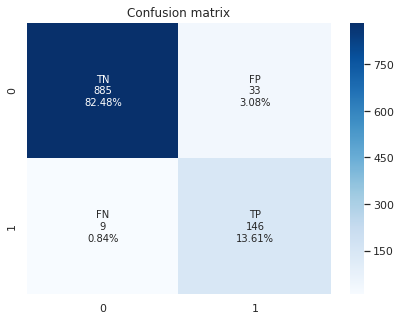

In [174]:
# without credibility
y_pred_rule = [1 if m > viral_strenght_threshold else 0 for m in X_test_viral]
get_test_metrics(y_test_superspreader, y_pred_rule, full_metrics = True)

In [181]:
viral_strenght_threshold

525.0

              precision    recall  f1-score   support

           0       0.99      0.97      0.98       918
           1       0.84      0.94      0.89       155

    accuracy                           0.97      1073
   macro avg       0.91      0.96      0.93      1073
weighted avg       0.97      0.97      0.97      1073



(0.9655172413793104,
 0.8390804597701149,
 0.9796367638965329,
 0.9419354838709677,
 0.9796367638965329,
 0.8875379939209727,
 0.9796367638965329,
 0)

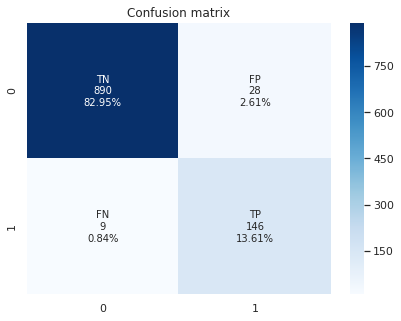

In [188]:
y_pred_superspreader = []
for viral,untrust in list(zip(X_test_viral,y_pred)):
    if viral > viral_strenght_threshold and untrust > 0.1:  #viral_strenght_threshold
        y_pred_superspreader.append(1)
    else:
        y_pred_superspreader.append(0)        
    
get_test_metrics(y_test_superspreader, y_pred_superspreader, full_metrics = True)

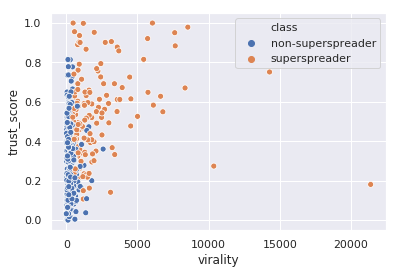

In [165]:
superspreader = ['superspreader' if x==1 else 'non-superspreader' for x in y_test_superspreader]
df_plot = pd.DataFrame({'virality':X_test_viral, 'trust_score':y_pred, 'class':superspreader})
sns.scatterplot(data=df_plot, x="virality", y="trust_score", hue = "class")